# Libre

In [49]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from math import ceil
from itertools import product
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [50]:
def load(filename: str):
    return pd.read_csv(filename)

In [51]:
data = load('../data/I3_25_nomot.csv')

In [52]:
def points_to_uncertainties(data: pd.Series, resolution: int = 10) -> np.ndarray:
    new_len: int = ceil(len(data) / resolution)
    avg: np.ndarray = np.zeros(new_len)
    std: np.ndarray = np.zeros(new_len)
    for i in range(new_len):
        subarr = data[resolution*i:resolution*(i+1)]
        avg[i] = np.mean(subarr)
        std[i] = np.max(subarr) - avg[i]
    return unp.uarray(avg, std)

In [53]:
def dataset_to_numpy(dataset: pd.DataFrame, resolution: int = 10) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    t = dataset["Temps"].iloc[::resolution].to_numpy()
    x = dataset["X"].iloc[::resolution].to_numpy()
    y = dataset["Y"].iloc[::resolution].to_numpy()
    return t, x, y

In [54]:
def dataset_to_uncertainties(dataset: pd.DataFrame, resolution: int = 10) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    t = dataset["Temps"].iloc[::resolution].to_numpy()
    x = points_to_uncertainties(dataset["X"], resolution)
    y = points_to_uncertainties(dataset["Y"], resolution)
    return t, x, y

In [77]:
def center(dataset: pd.DataFrame, from_time: float = 0.0, until_time: float = None) -> pd.DataFrame:
    exclude = dataset["Temps"] < from_time
    if until_time is not None:
        exclude = np.logical_or(exclude, dataset["Temps"] > until_time)
    idx = np.where(exclude)[0]
    df = dataset.drop(idx)
    df["Temps"] -= df["Temps"].iat[0]
    df["X"] -= np.mean(df["X"])
    df["Y"] -= np.mean(df["Y"])
    return df

# Do the calcs

In [56]:
def fit_func(x, A, lmda):
    return A * np.exp(-lmda * x)

In [62]:
def fit_exp(t: np.ndarray, y: np.ndarray) -> np.ndarray:
    maxs = sc.signal.argrelmax(nom_vals(y))[0]
    mins = sc.signal.argrelmin(nom_vals(y))[0]

    all_idx = np.concatenate((mins, maxs))
    coefs, cov = sc.optimize.curve_fit(fit_func, nom_vals(t[all_idx]), nom_vals(np.abs(y[all_idx])))
    coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))

    return coefs_err

In [58]:
def calc_lambda(t: np.ndarray, y: np.ndarray):
    return fit_exp(t, y)[1]

In [167]:
def calc_omega_hmmm(t: np.ndarray, y: np.ndarray):
    maxs = sc.signal.argrelmax(nom_vals(y), order=10)[0]

    period = (ufloat(t[maxs[-1]], 0.05) - ufloat(t[maxs[0]], 0.05)) / (len(maxs) - 1)

    for mx in maxs:
        plt.axvline(t[mx])

    return 2 * np.pi / period

0.193+/-0.012 2.869+/-0.015


<ErrorbarContainer object of 3 artists>

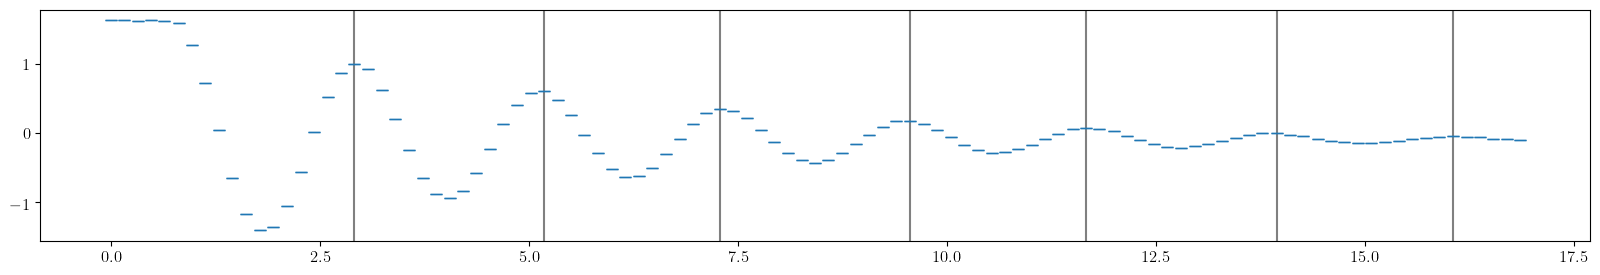

In [168]:
# Testing site
plt.figure(figsize=(20, 3))
t, x, y = dataset_to_numpy(center(data, 0), 2)
print(calc_lambda(t, x), calc_omega_hmmm(t, x))

plt.errorbar(nom_vals(t), nom_vals(x), yerr=std_devs(x), ls='none')

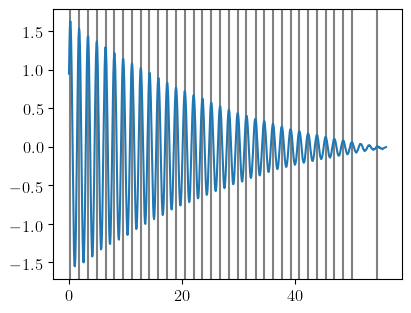

In [169]:
# Problematic
%matplotlib inline
data = load(f'../data/I{''}_{25}_nomot.csv')
t, x, y = dataset_to_numpy(center(data, 2), 1)
calc_omega_hmmm(t, x)
plt.plot(t, x)

Masses = 0, amort = 0%: lambda = 0.0218±0.0003, omega = 4.04+/-0.01
Masses = 0, amort = 25%: lambda = 0.037±0.001, omega = 4.02+/-0.02
Masses = 0, amort = 50%: lambda = 0.109±0.005, omega = 4.03+/-0.05
Masses = 0, amort = 75%: lambda = 0.249±0.006, omega = 4.07+/-0.05
Masses = 0, amort = 100%: lambda = 0.43±0.01, omega = 3.98+/-0.09
Masses = 2, amort = 0%: lambda = 0.0166±0.0002, omega = 3.14+/-0.01
Masses = 2, amort = 25%: lambda = 0.0242±0.0006, omega = 3.15+/-0.01
Masses = 2, amort = 50%: lambda = 0.063±0.002, omega = 3.14+/-0.04
Masses = 2, amort = 75%: lambda = 0.144±0.005, omega = 3.11+/-0.05
Masses = 2, amort = 100%: lambda = 0.25±0.06, omega = 3.17+/-0.06
Masses = 3, amort = 0%: lambda = 0.0165±0.0004, omega = 2.88+/-0.01
Masses = 3, amort = 25%: lambda = 0.022±0.002, omega = 2.88+/-0.01
Masses = 3, amort = 50%: lambda = 0.05±0.01, omega = 2.88+/-0.03
Masses = 3, amort = 75%: lambda = 0.112±0.008, omega = 2.87+/-0.03
Masses = 3, amort = 100%: lambda = 0.201±0.004, omega = 2.87+

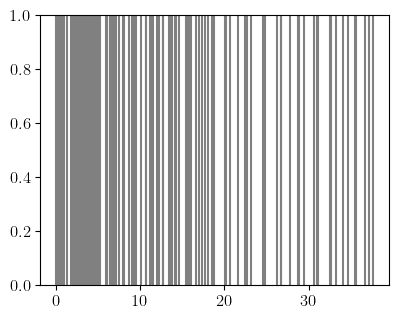

In [170]:
# Prod
tf = {
    0: 40,
    25: 20,
    50: 10,
    75: 10,
    100: 7
}

I0_lambda = unp.uarray(range(5), 0)
I2_lambda = unp.uarray(range(5), 0)
I3_lambda = unp.uarray(range(5), 0)
I0_omega = unp.uarray(range(5), 0)
I2_omega = unp.uarray(range(5), 0)
I3_omega = unp.uarray(range(5), 0)
for masse in [0, 2, 3]:
    for i, amort in enumerate([0, 25, 50, 75, 100]):
        data = load(f'../data/I{masse if masse != 0 else ''}_{amort}_nomot.csv')
        t, x, y = dataset_to_numpy(center(data, 2, tf[amort]), 1)
        lmda = calc_lambda(t, x)
        omega = calc_omega_hmmm(t, x)
        # plt.plot(t, x)
        # plt.show()
        # Cursed shit - DO NOT TOUCH OR YOU WILL EXPLODE (kinda, not guaranteed)
        exec(f'I{masse}_lambda[{i}]=ufloat({lmda.n},{lmda.s})')
        exec(f'I{masse}_omega[{i}]=ufloat({omega.n},{omega.s})')
        print(f"Masses = {masse if masse else 0}, amort = {amort}%: lambda = {lmda:.1uP}, omega = {omega:.2f}")

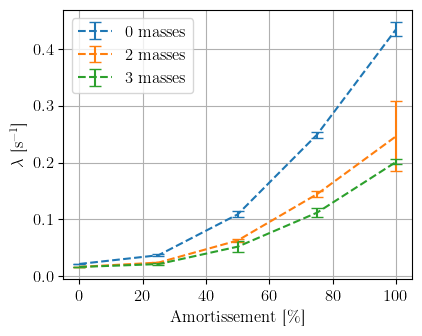

In [176]:
plt.errorbar(np.arange(0, 101, 25), nom_vals(I0_lambda), yerr=std_devs(I0_lambda), fmt='--', label='0 masses')
plt.errorbar(np.arange(0, 101, 25), nom_vals(I2_lambda), yerr=std_devs(I2_lambda), fmt='--', label='2 masses')
plt.errorbar(np.arange(0, 101, 25), nom_vals(I3_lambda), yerr=std_devs(I3_lambda), fmt='--', label='3 masses')

plt.xlabel(r'Amortissement [\%]')
plt.ylabel(r'$\lambda$ [\si{\per\second}]')
plt.legend()
plt.grid()

plt.savefig('../figures/lambda_nomot.pdf')

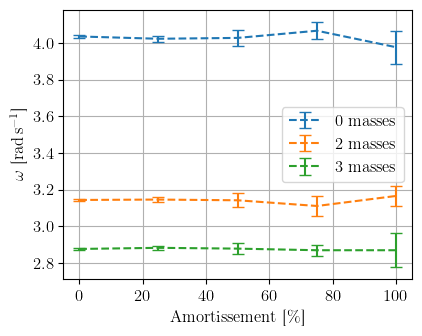

In [175]:
plt.errorbar(np.arange(0, 101, 25), nom_vals(I0_omega), yerr=std_devs(I0_omega), fmt='--', label='0 masses')
plt.errorbar(np.arange(0, 101, 25), nom_vals(I2_omega), yerr=std_devs(I2_omega), fmt='--', label='2 masses')
plt.errorbar(np.arange(0, 101, 25), nom_vals(I3_omega), yerr=std_devs(I3_omega), fmt='--', label='3 masses')

plt.xlabel(r'Amortissement [\%]')
plt.ylabel(r'$\omega$ [\si{\radian\per\second}]')
plt.legend()
plt.grid()
plt.savefig('../figures/omega_nomot.pdf')

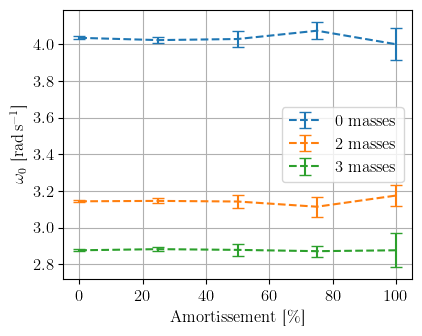

In [180]:
I0_omega0 = unp.sqrt(I0_lambda**2 + I0_omega**2)
I2_omega0 = unp.sqrt(I2_lambda**2 + I2_omega**2)
I3_omega0 = unp.sqrt(I3_lambda**2 + I3_omega**2)

plt.errorbar(np.arange(0, 101, 25), nom_vals(I0_omega0), yerr=std_devs(I0_omega0), fmt='--', label='0 masses')
plt.errorbar(np.arange(0, 101, 25), nom_vals(I2_omega0), yerr=std_devs(I2_omega0), fmt='--', label='2 masses')
plt.errorbar(np.arange(0, 101, 25), nom_vals(I3_omega0), yerr=std_devs(I3_omega0), fmt='--', label='3 masses')

plt.xlabel(r'Amortissement [\%]')
plt.ylabel(r'$\omega_0$ [\si{\radian\per\second}]')
plt.legend()
plt.grid()
plt.savefig('../figures/omega0_nomot.pdf')